In [47]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

In [48]:
sns.set_style("white")

In [49]:
# Display figures at a reasonable default size.
mpl.rcParams['figure.figsize'] = (6, 4)

# Disable top and right spines.
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
    
# Display and save figures at higher resolution for presentations and manuscripts.
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 300

# Display text at sizes large enough for presentations and manuscripts.
mpl.rcParams['font.weight'] = "normal"
mpl.rcParams['axes.labelweight'] = "normal"
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

## Load data

Load exhaustive grid search data. For each possible embedding method, corresponding method parameters, and HDBSCAN distance threshold, we produced an embedding for training and validation data (using 2-fold validation with 3 repeats for N=6 cross-validation iterations per parameter combination), assigned clusters to each embedding, and evaluated how well all pairs of strains in the data were assigned to the same or different cluster compared to predetermined clade assignments.

In [50]:
grid = pd.read_csv("results/gridsearch.tsv", sep="\t")

In [51]:
grid.head()

,cv_iteration,distance_threshold,init,learning_rate,method,metric,min_dist,n_neighbors,perplexity,random_state,...,training_fn,training_fp,training_mcc,training_tn,training_tp,validation_fn,validation_fp,validation_mcc,validation_tn,validation_tp
0,0,0.0,NaN,100.0,t-sne,precomputed,NaN,NaN,15.0,12883823,...,33768,2535,0.551815,389849,20833,41348,4249,0.344724,391788,10546
1,1,0.0,NaN,100.0,t-sne,precomputed,NaN,NaN,15.0,12883823,...,41348,4249,0.344724,391788,10546,33768,2535,0.551815,389849,20833
2,2,0.0,NaN,100.0,t-sne,precomputed,NaN,NaN,15.0,12883823,...,41441,3846,0.339981,391707,9991,43476,3158,0.372349,389717,11580
3,3,0.0,NaN,100.0,t-sne,precomputed,NaN,NaN,15.0,12883823,...,43476,3158,0.372349,389717,11580,41441,3846,0.339981,391707,9991
4,4,0.0,NaN,100.0,t-sne,precomputed,NaN,NaN,15.0,12883823,...,42439,6420,0.331905,386346,11780,38498,5241,0.398961,390390,13802


In [52]:
list(grid.columns)

['cv_iteration',
 'distance_threshold',
 'init',
 'learning_rate',
 'method',
 'metric',
 'min_dist',
 'n_neighbors',
 'perplexity',
 'random_state',
 'square_distances',
 'training_fn',
 'training_fp',
 'training_mcc',
 'training_tn',
 'training_tp',
 'validation_fn',
 'validation_fp',
 'validation_mcc',
 'validation_tn',
 'validation_tp']

## Identify the distance threshold that maximized the training accuracy

We want to identify the distance threshold for HDBSCAN cluster assignment that produces the most accurate clusters (based on known clade assignments) across each method. To find this optimal threshold, we calculate the mean training MCC value across all cross-validation iterations for a given method and set of method parameters and find the threshold that maximizes this mean across each method.

In [56]:
mean_training_mcc_by_method = grid.groupby(["method", "distance_threshold"])["training_mcc"].mean().reset_index()

In [65]:
mean_training_mcc_by_method

,method,distance_threshold,training_mcc
0,t-sne,0.0,0.272122
1,t-sne,2.0,0.587550
2,t-sne,4.0,0.654850
3,t-sne,6.0,0.610043
4,t-sne,8.0,0.588056
5,t-sne,10.0,0.572459
6,t-sne,12.0,0.551224
7,t-sne,14.0,0.503618
8,umap,0.0,0.309769
9,umap,2.0,0.671681


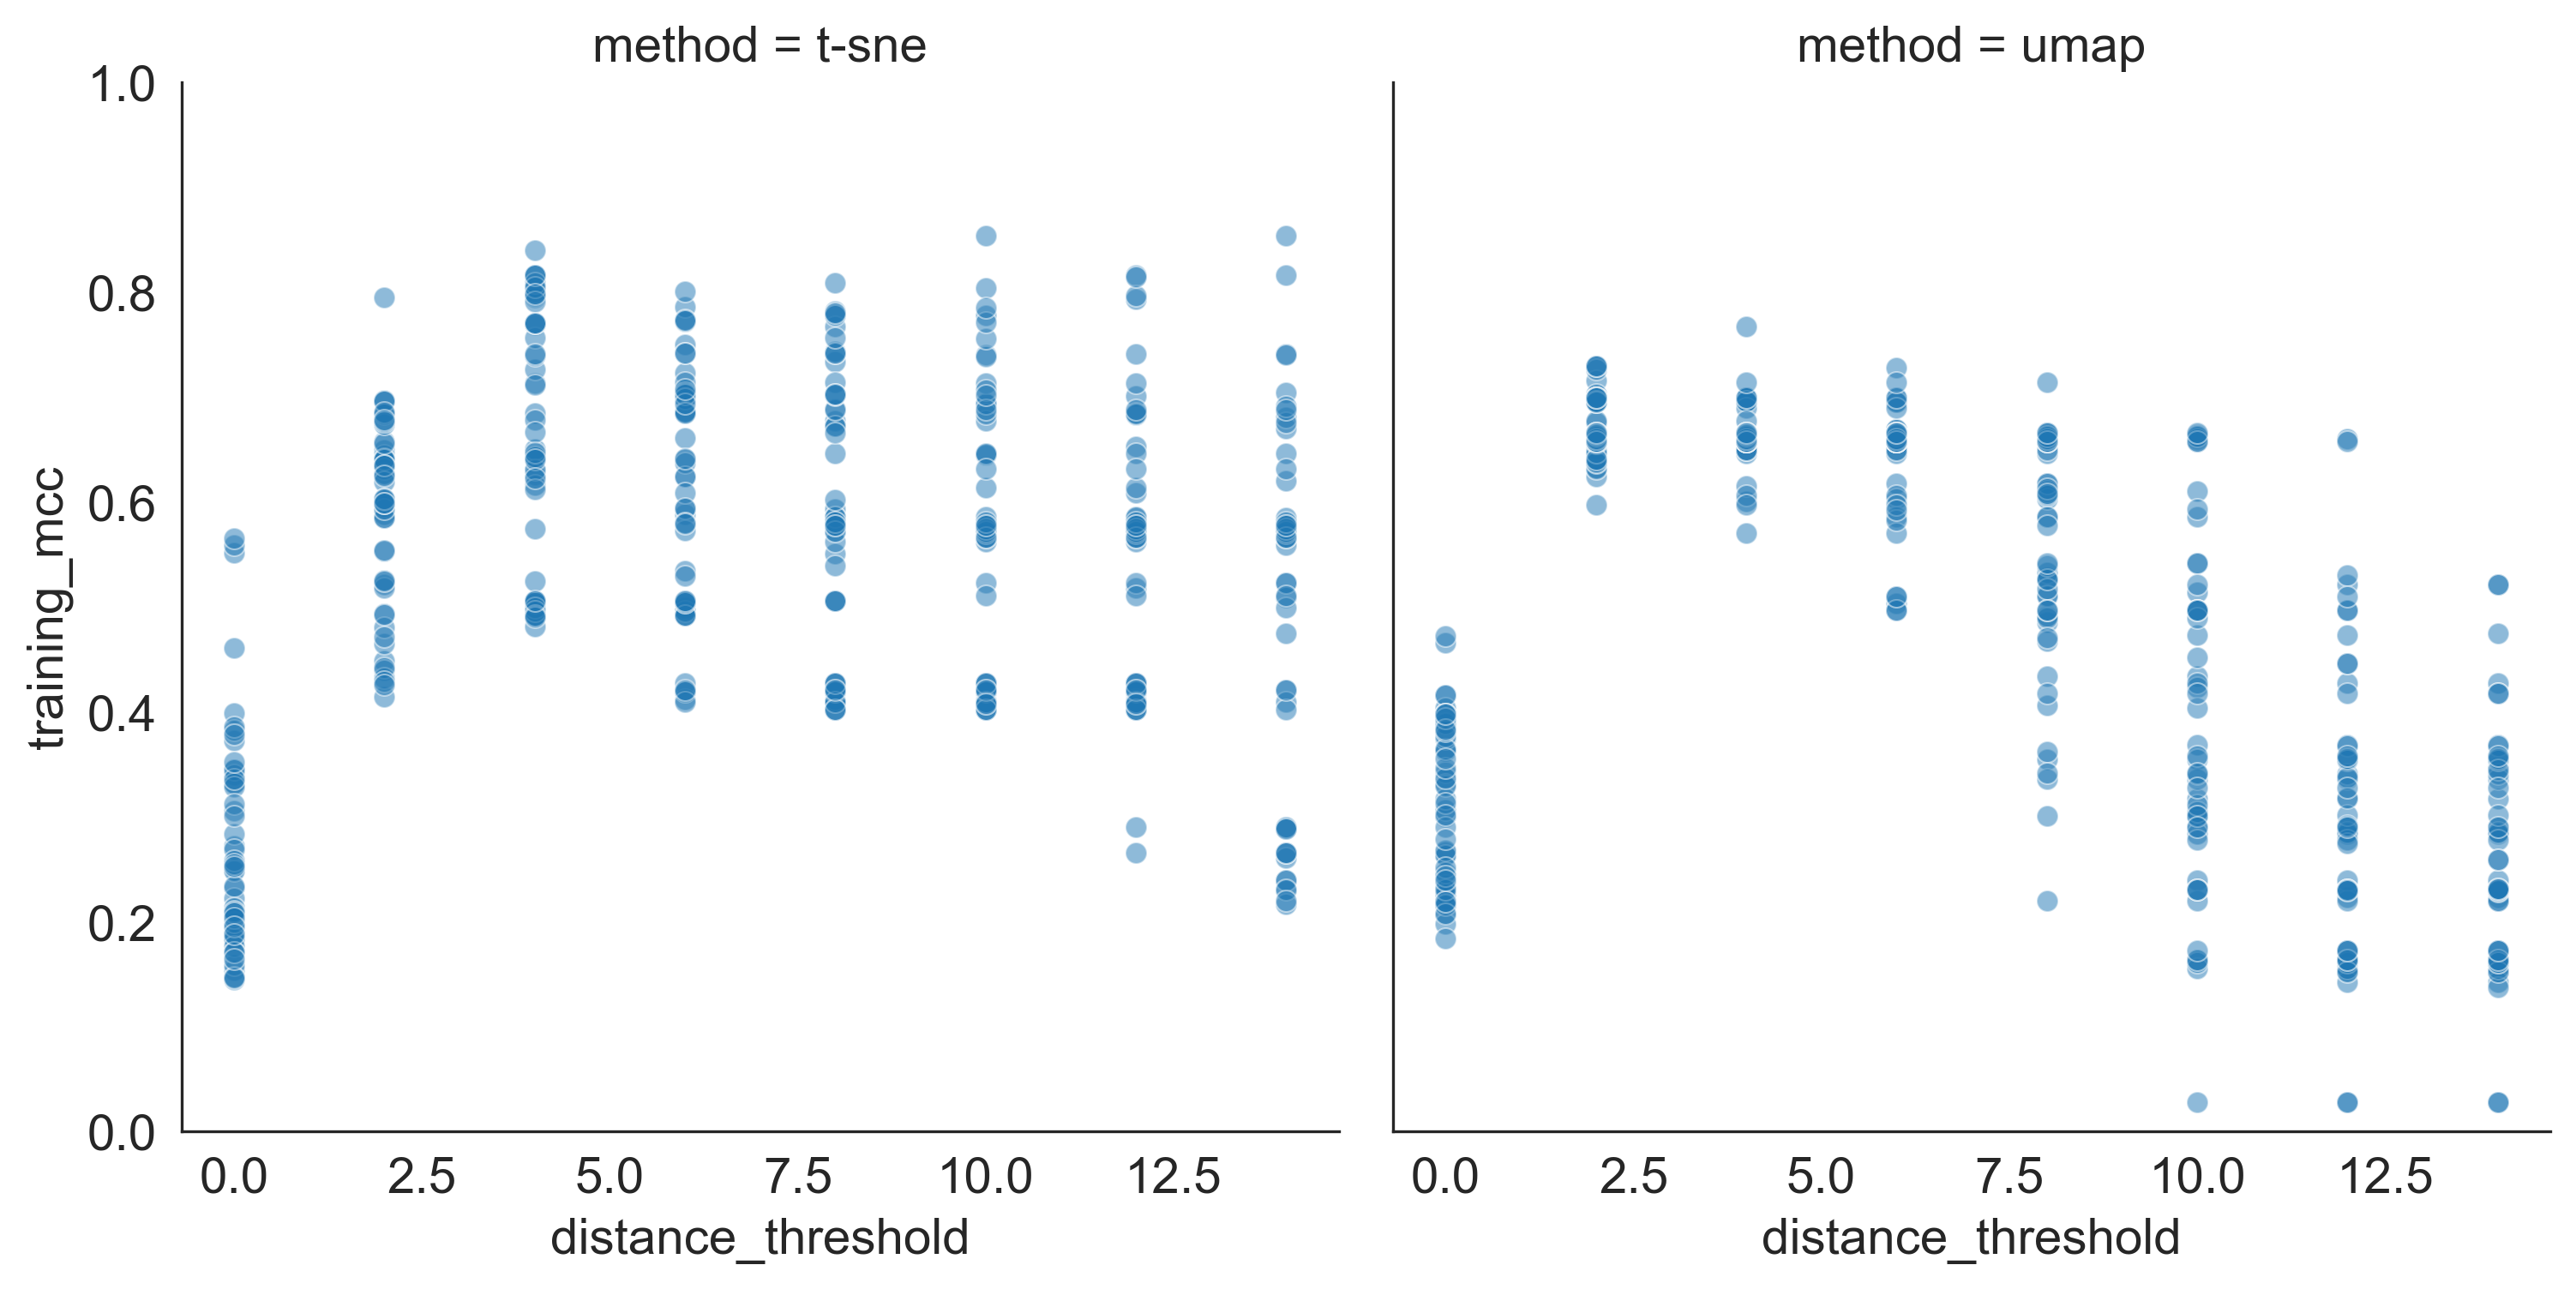

In [61]:
facet_grid = sns.relplot(
    data=grid,
    x="distance_threshold",
    y="training_mcc",
    col="method",
    alpha=0.5,
)

for ax in facet_grid.axes.flatten():
    ax.set_ylim(0, 1)

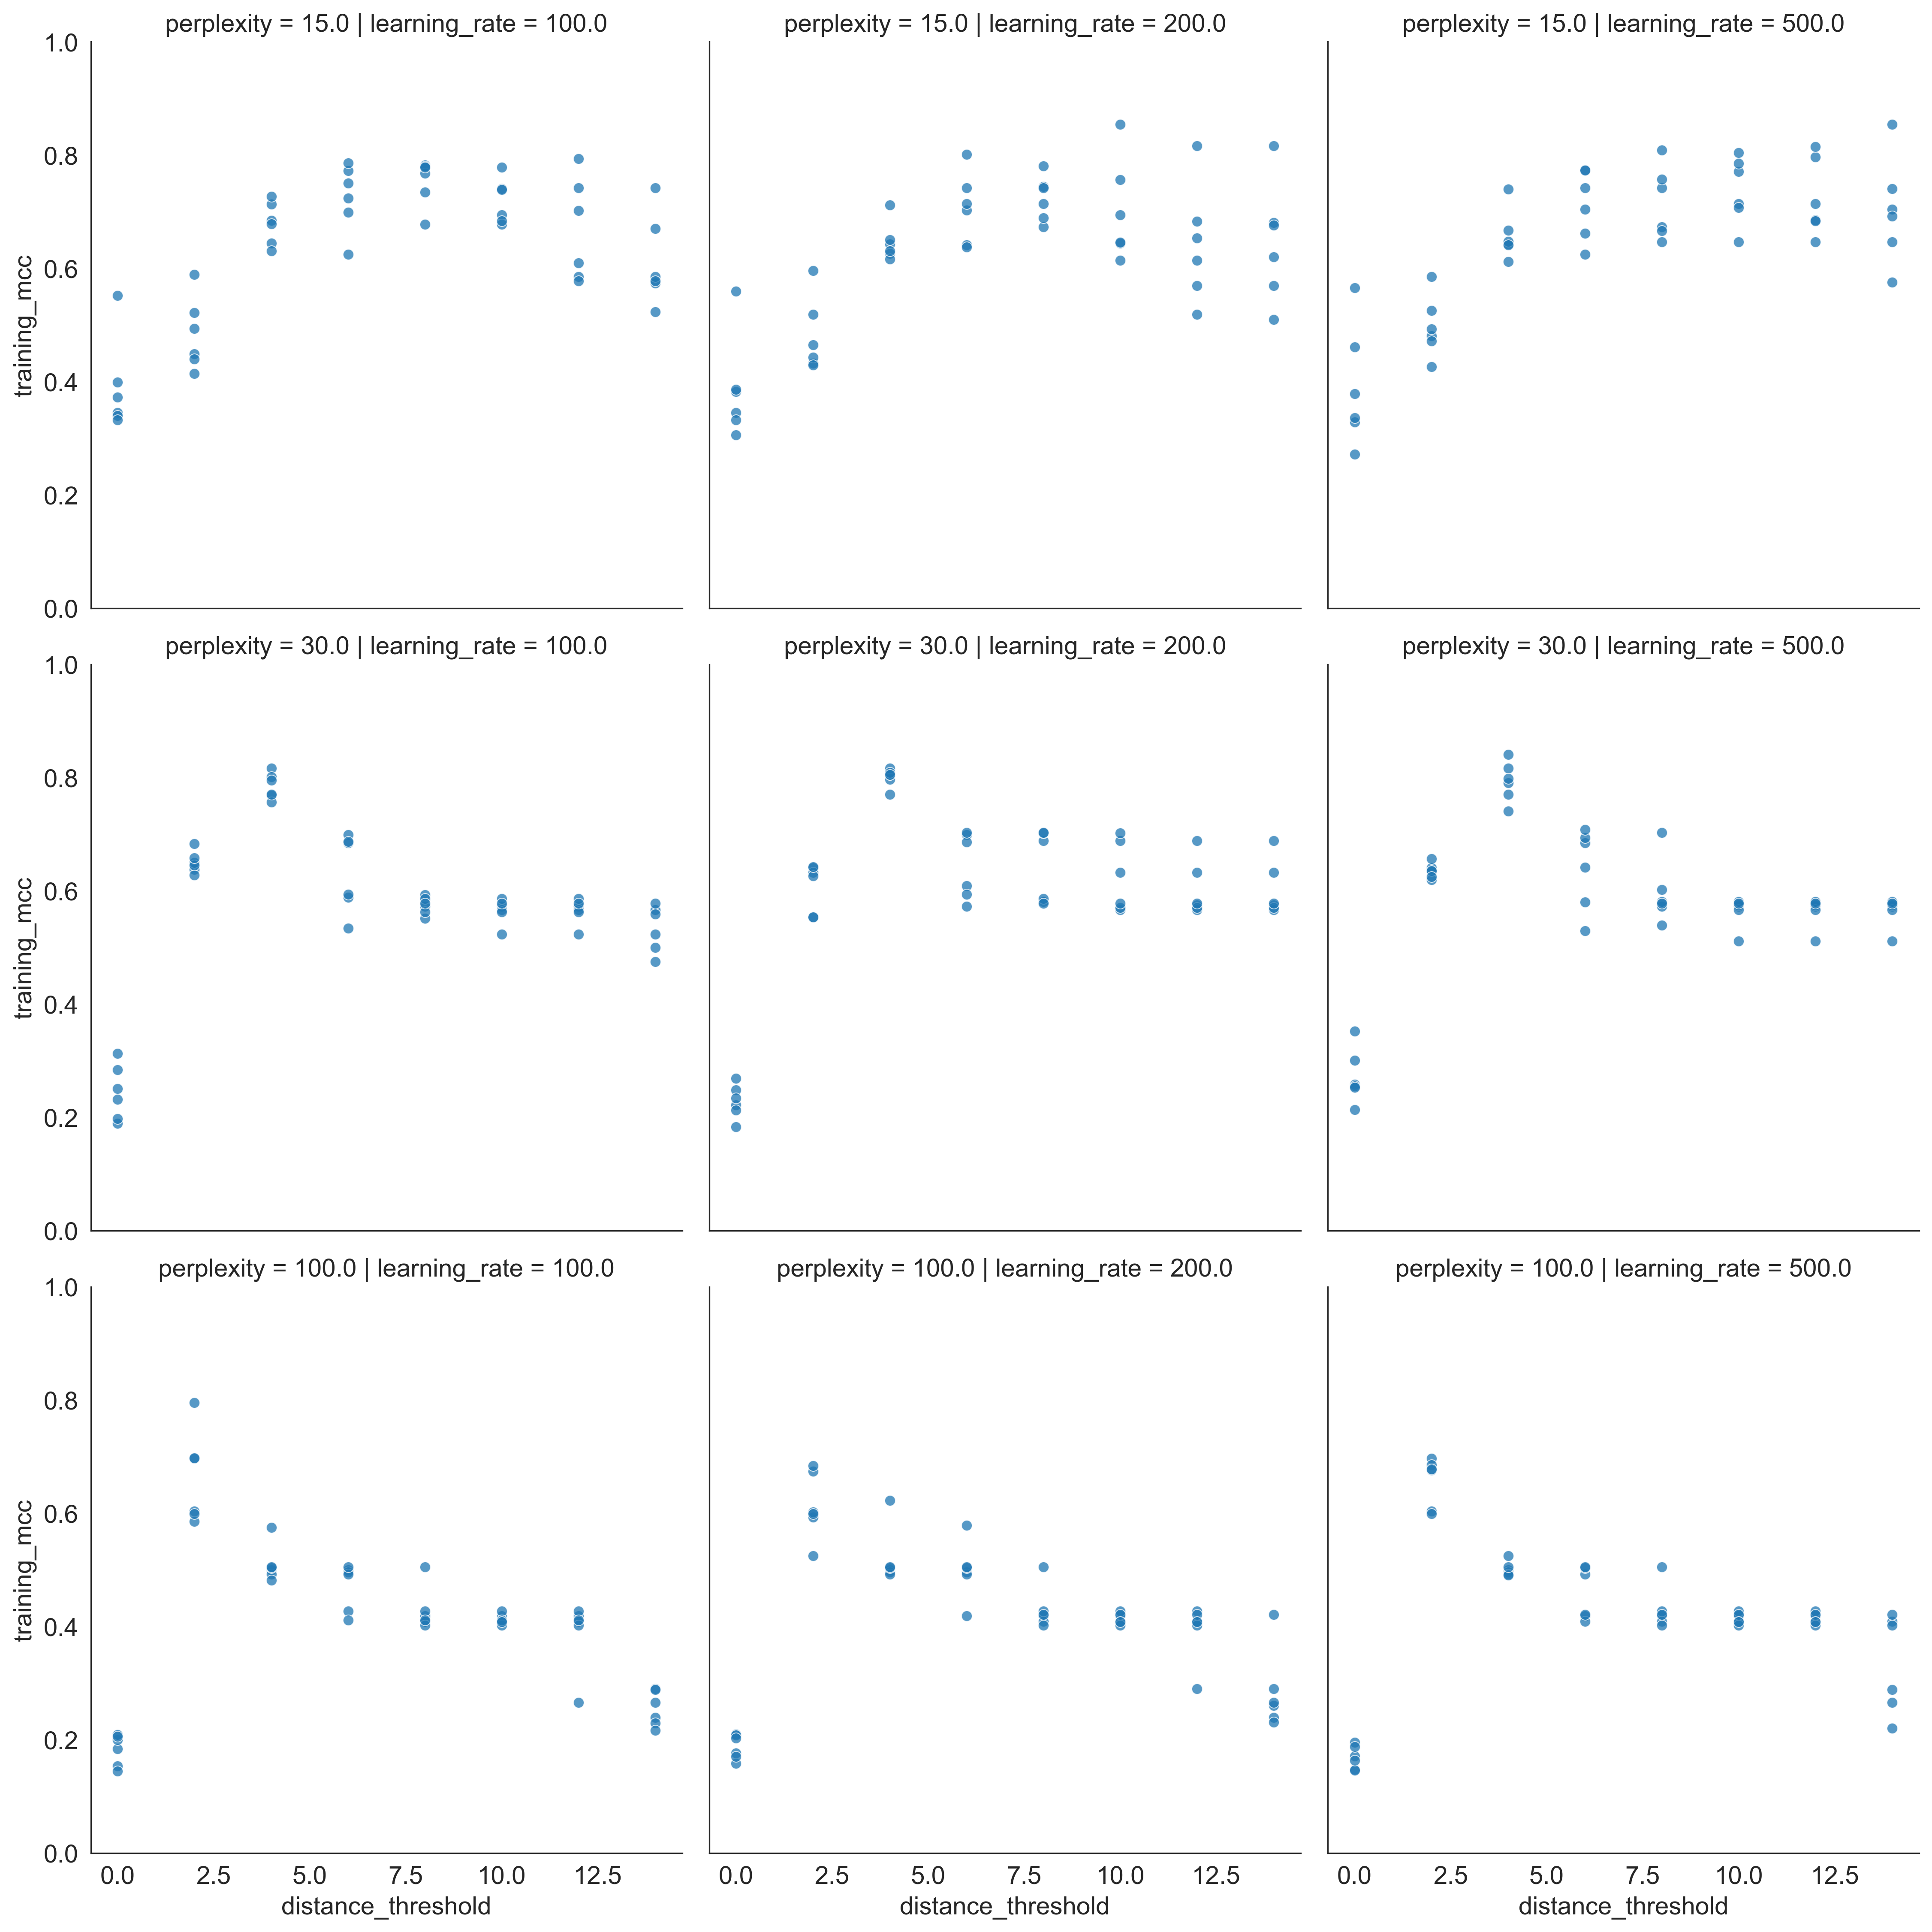

In [63]:
facet_grid = sns.relplot(
    data=grid.query("method == 't-sne'"),
    x="distance_threshold",
    y="training_mcc",
    col="learning_rate",
    row="perplexity",
    alpha=0.75,
)

for ax in facet_grid.axes.flatten():
    ax.set_ylim(0, 1)

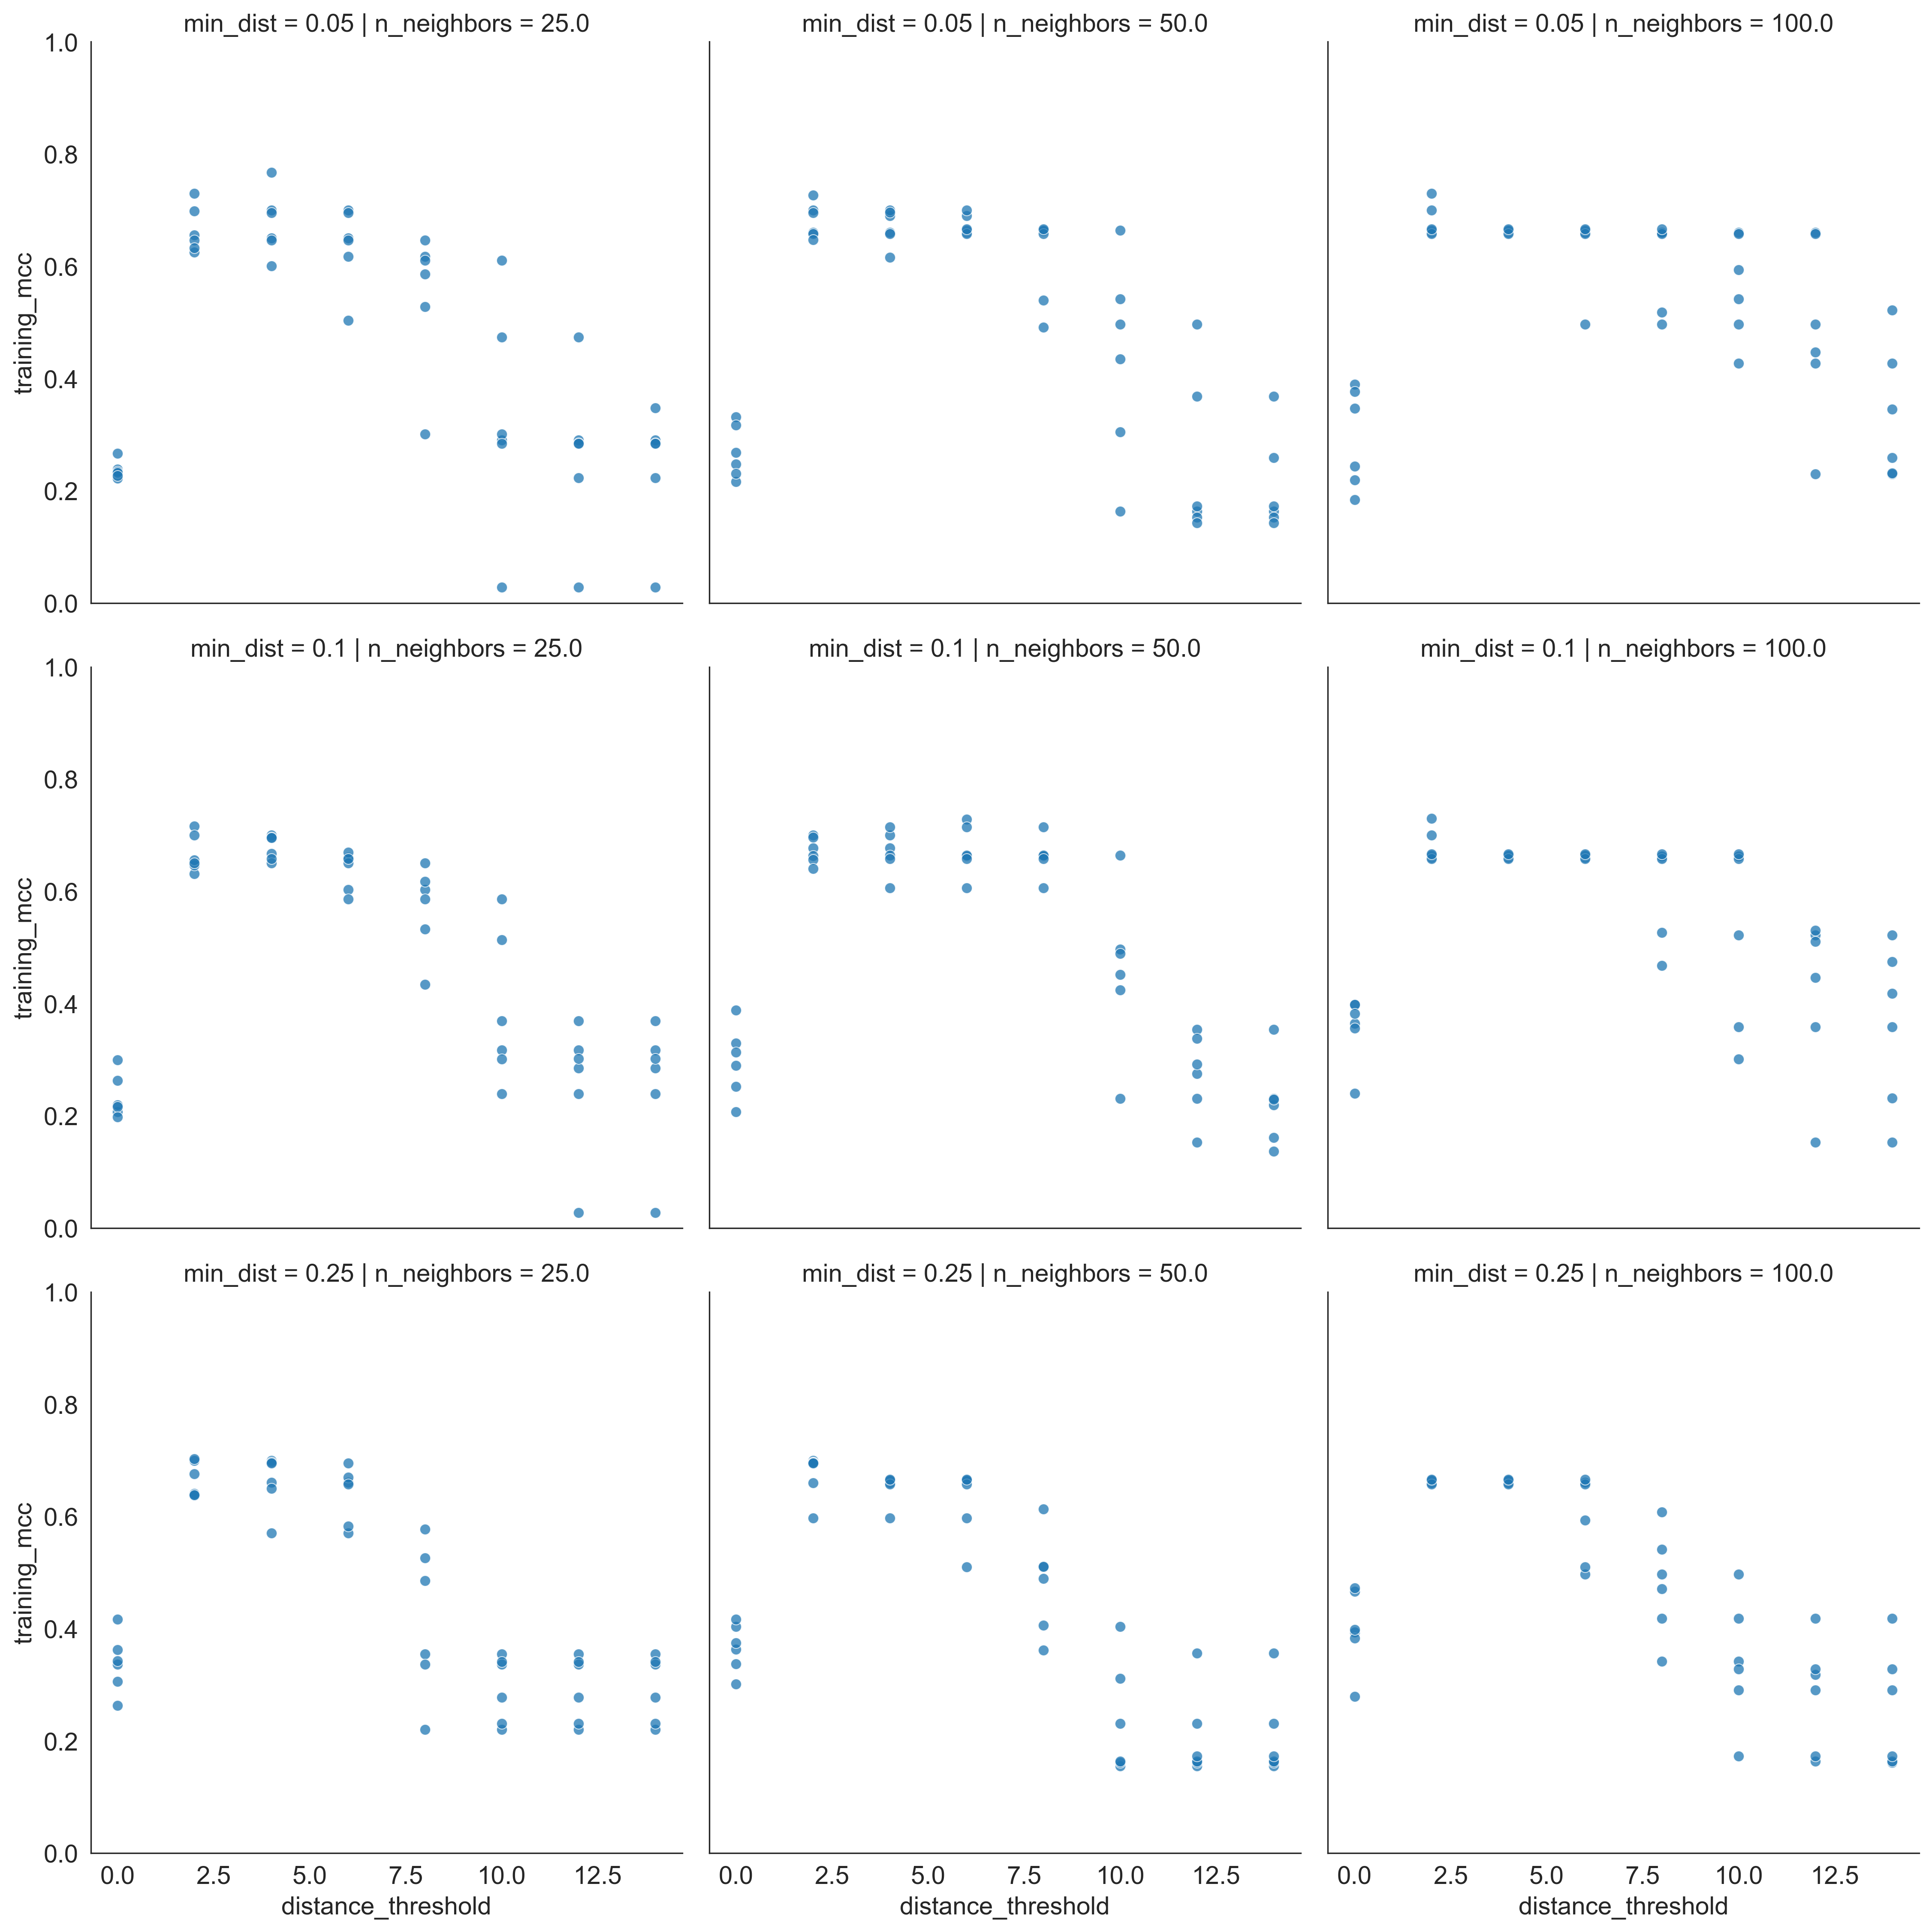

In [64]:
facet_grid = sns.relplot(
    data=grid.query("method == 'umap'"),
    x="distance_threshold",
    y="training_mcc",
    col="n_neighbors",
    row="min_dist",
    alpha=0.75,
)

for ax in facet_grid.axes.flatten():
    ax.set_ylim(0, 1)

## Identify optimal method parameter values

Given the distance threshold that maximizes the training MCC above (threshold=4 for t-SNE and threshold=2 for UMAP), we next identify the combination of method parameters that maximizes the validation MCC for that distance threshold.

In [91]:
grid.query("distance_threshold == 4").groupby(["method", "perplexity", "learning_rate"])["validation_mcc"].mean().reset_index().sort_values(
    "validation_mcc",
    ascending=False
)

,method,perplexity,learning_rate,validation_mcc
4,t-sne,30.0,200.0,0.800371
5,t-sne,30.0,500.0,0.792893
3,t-sne,30.0,100.0,0.784715
0,t-sne,15.0,100.0,0.679711
2,t-sne,15.0,500.0,0.658334
1,t-sne,15.0,200.0,0.646351
7,t-sne,100.0,200.0,0.520073
6,t-sne,100.0,100.0,0.509694
8,t-sne,100.0,500.0,0.501505


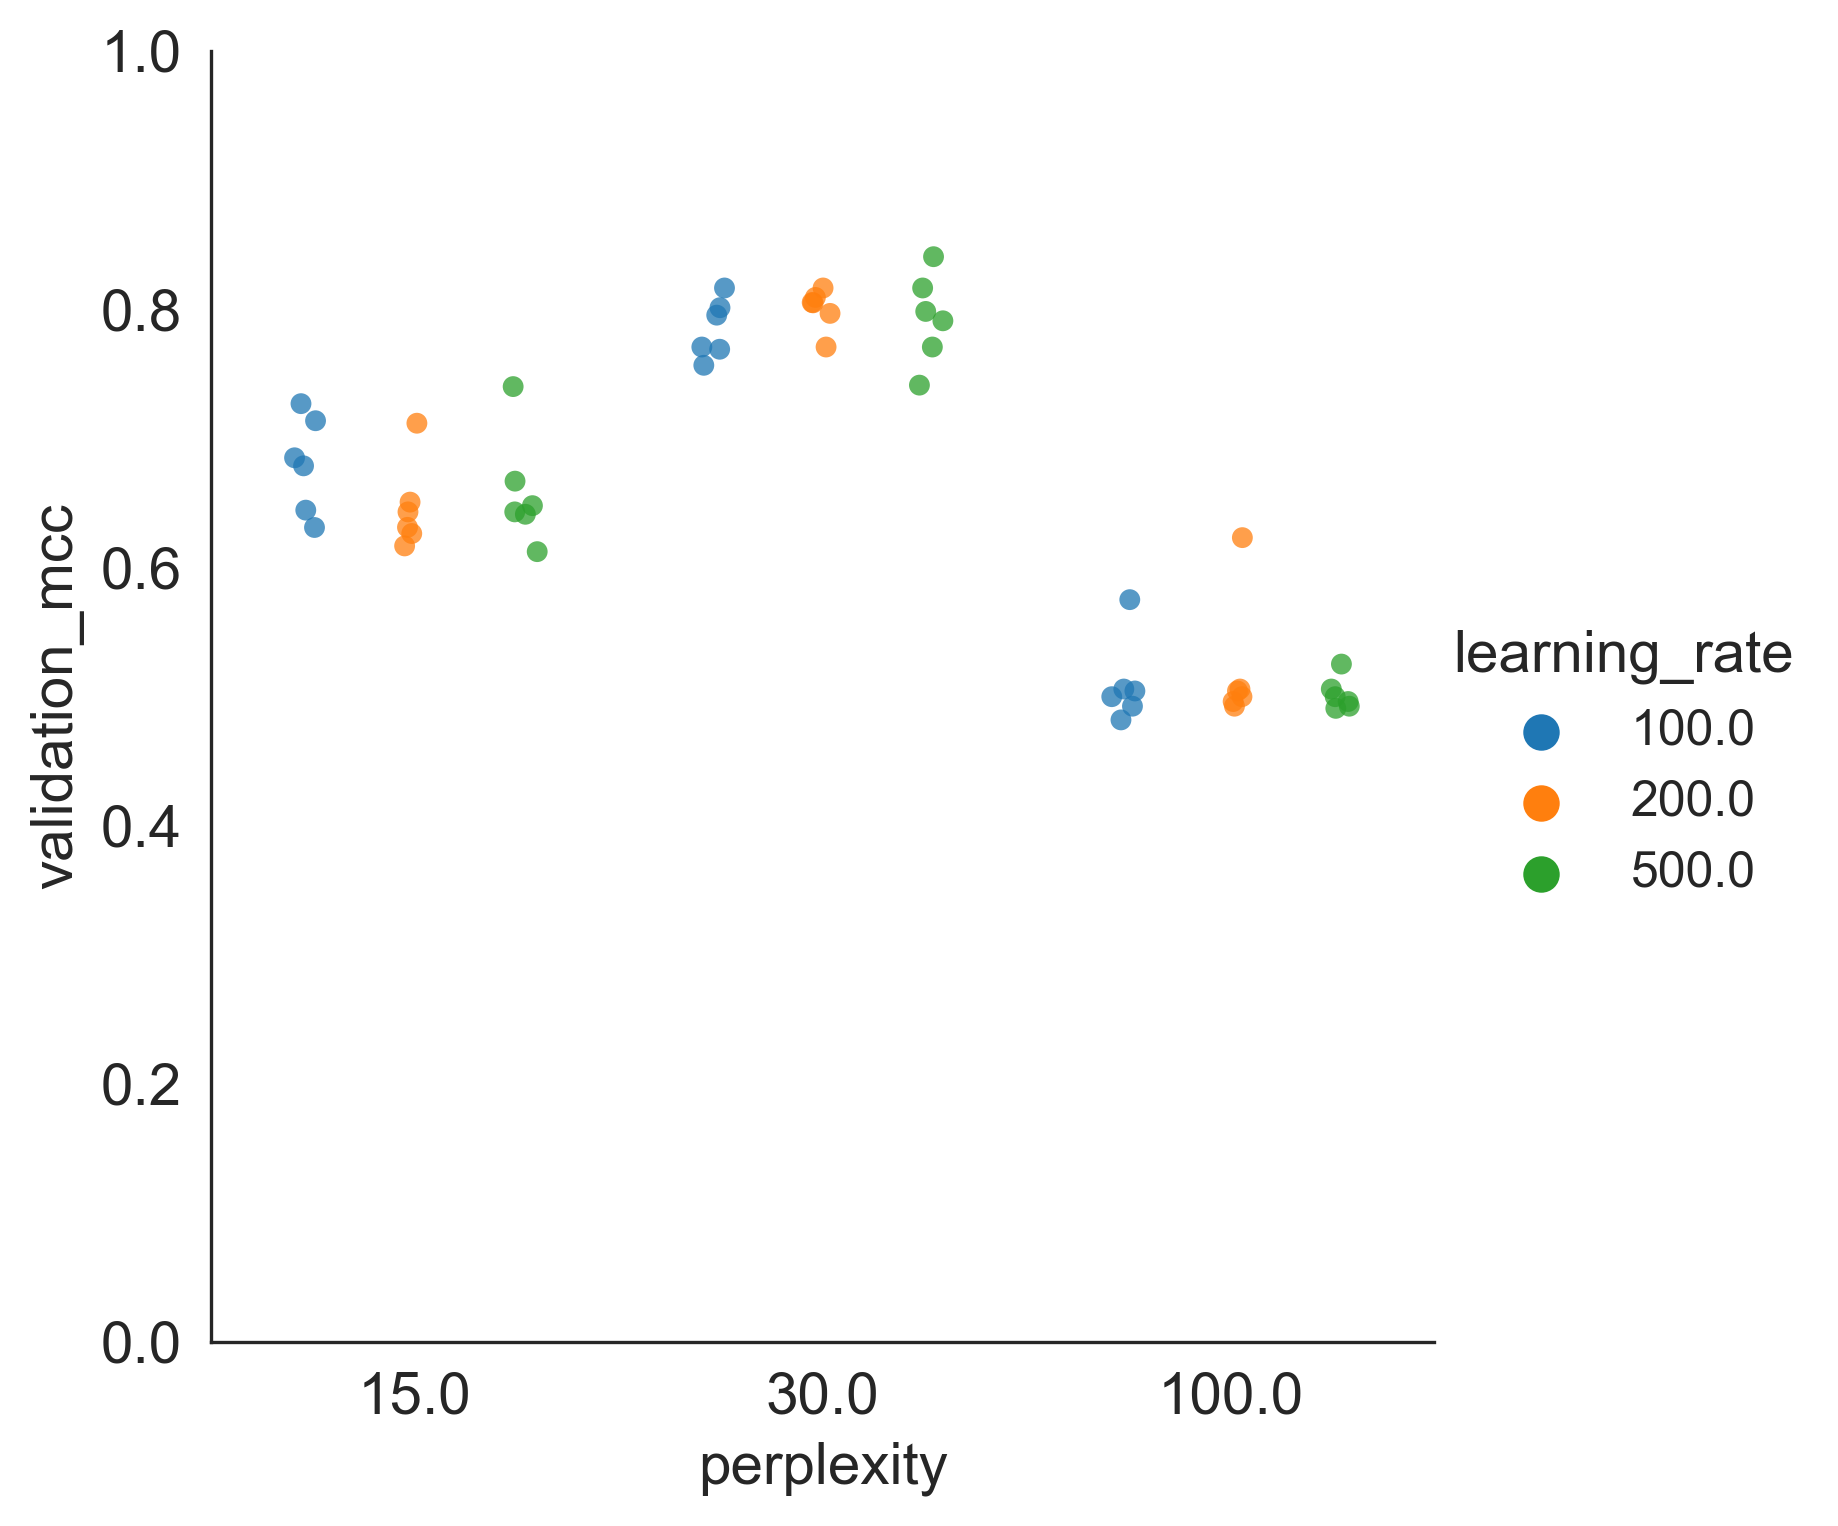

In [97]:
facet_grid = sns.catplot(
    data=grid.query("(method == 't-sne') & (distance_threshold == 4)"),
    x="perplexity",
    y="validation_mcc",
    hue="learning_rate",
    dodge=True,
    alpha=0.75,
)

for ax in facet_grid.axes.flatten():
    ax.set_ylim(0, 1)

As we’ve seen before, learning rate doesn’t matter much, but perplexity does. The maximum validation MCC for t-SNE is at perplexity=30 and learning rate = 200, which is what we’ve been using.

In [92]:
grid.query("distance_threshold == 2").groupby(["method", "min_dist", "n_neighbors"])["validation_mcc"].mean().reset_index().sort_values(
    "validation_mcc",
    ascending=False
)

,method,min_dist,n_neighbors,validation_mcc
1,umap,0.05,50.0,0.681042
2,umap,0.05,100.0,0.679614
5,umap,0.10,100.0,0.679614
7,umap,0.25,50.0,0.673934
4,umap,0.10,50.0,0.672242
3,umap,0.10,25.0,0.666571
6,umap,0.25,25.0,0.665775
0,umap,0.05,25.0,0.664459
8,umap,0.25,100.0,0.661873


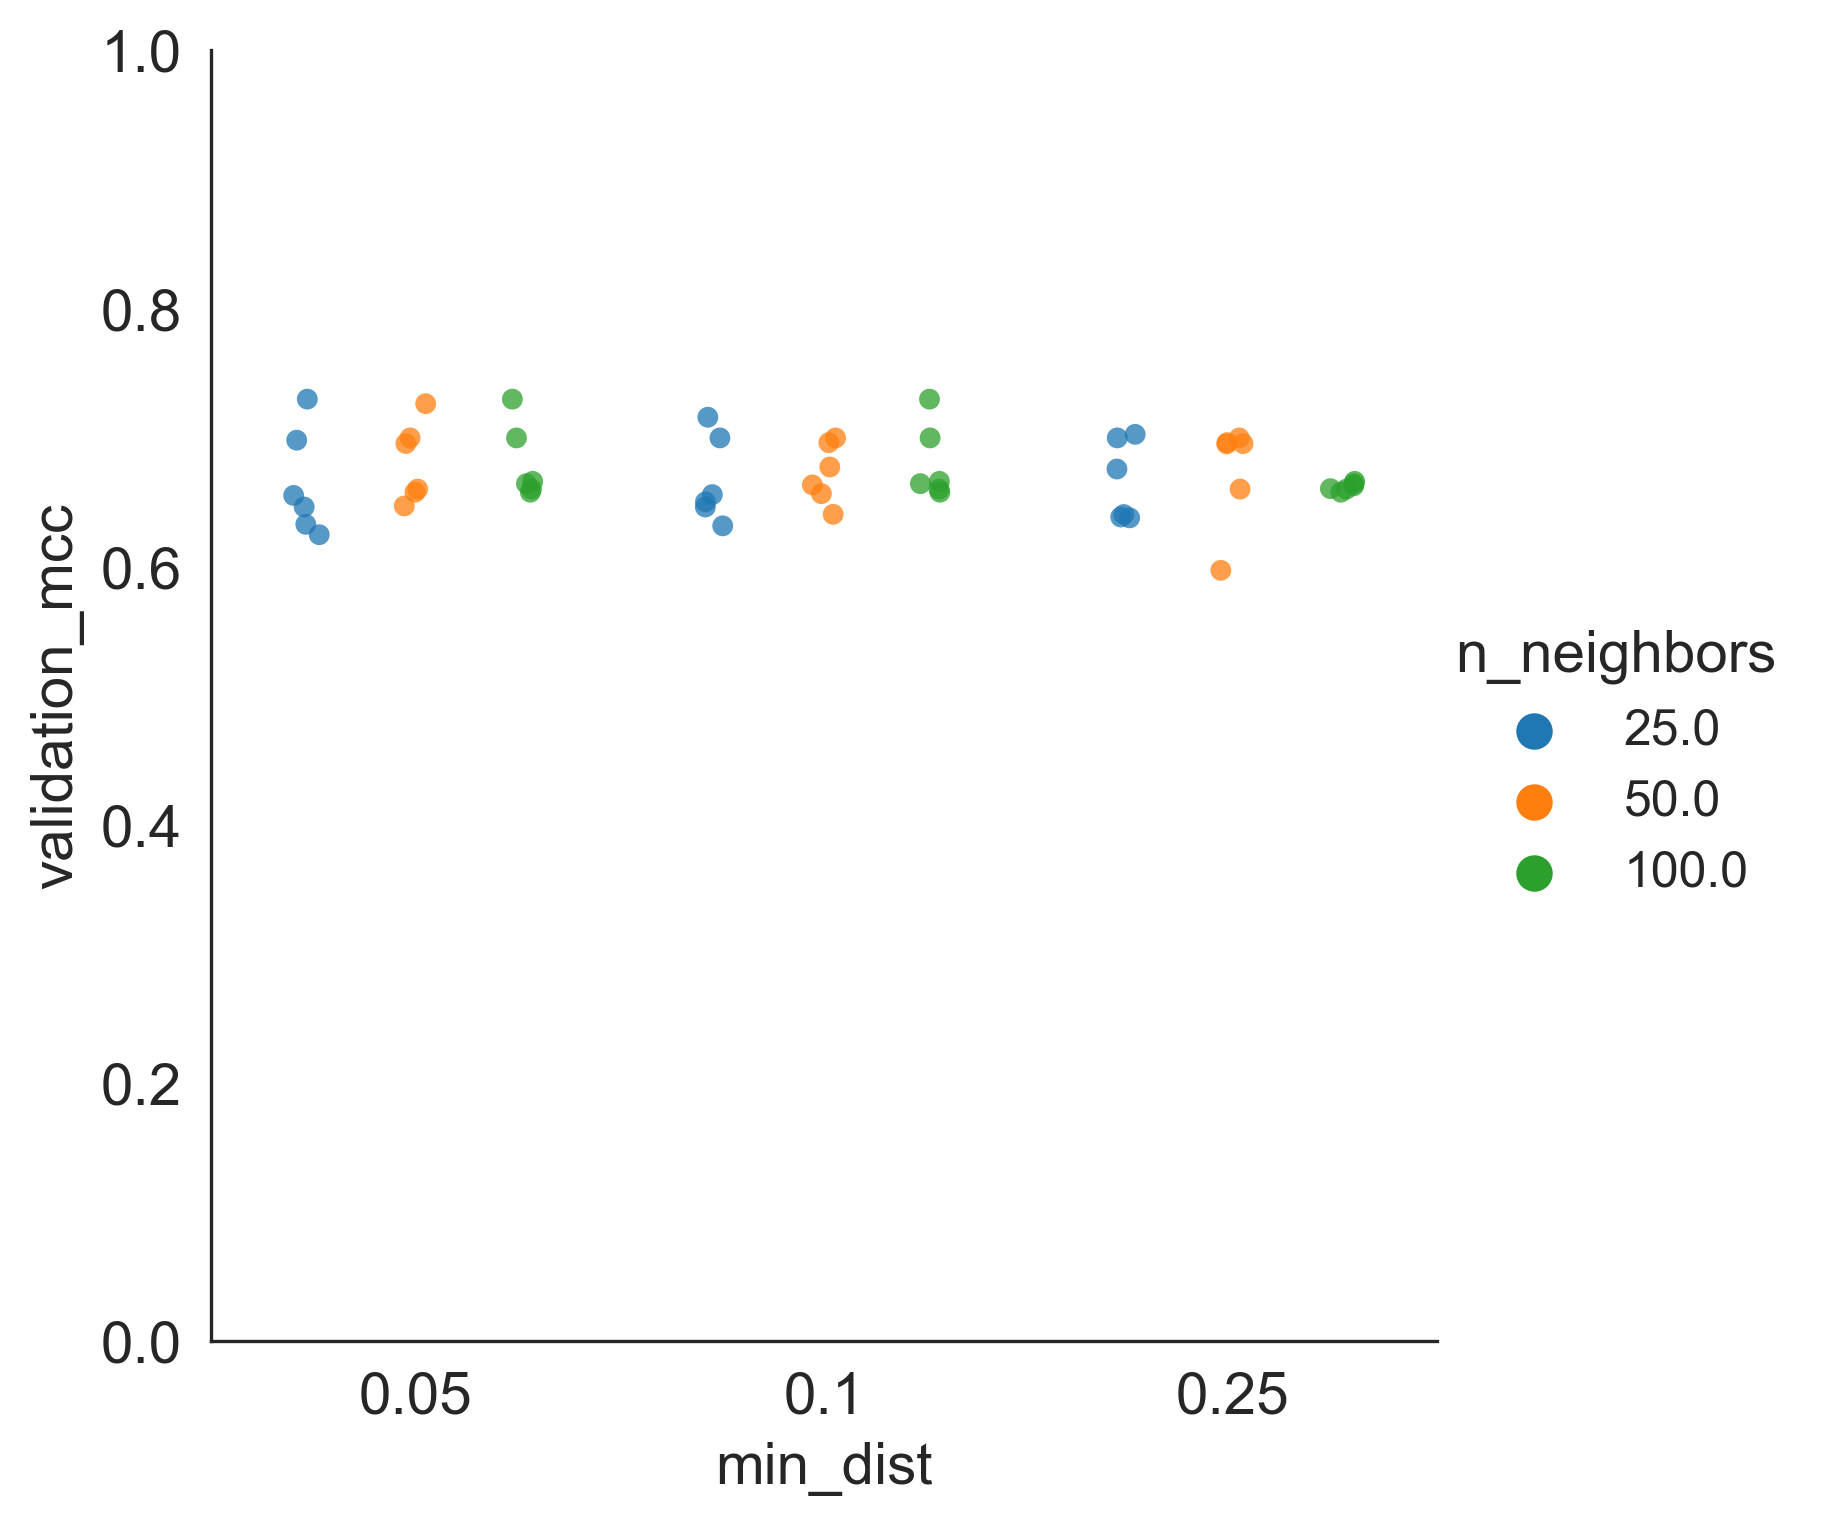

In [94]:
facet_grid = sns.catplot(
    data=grid.query("(method == 'umap') & (distance_threshold == 2)"),
    x="min_dist",
    y="validation_mcc",
    hue="n_neighbors",
    dodge=True,
    alpha=0.75,
)

for ax in facet_grid.axes.flatten():
    ax.set_ylim(0, 1)

In contrast with t-SNE's parameters, UMAP appears robust across all tested parameter combinations, producing roughly the same MCC values for all combinations. Although the optimal parameter combination is min_dist=0.05, n_neighbors=50 (MCC=0.681), the second best combination of min_dist=0.05, n_neighbors=100 has an MCC=0.6796).